In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl





In [7]:
# 1. CARICAMENTO E PULIZIA DATI
df = pd.read_excel('TimeSeries/Dataset-Project-Deep-Learning-SMRES-Unificato.xlsx')

In [8]:
df.describe()

,Data,Potenza Uffici [W],Temperatura [K],Nuvolosità [%],Irraggiamento [kWh/m2]
count,13104,13104.000000,13104.000000,13104.000000,13104.000000
mean,2021-09-30 11:59:59.999999744,69626.025946,289.407343,18.189408,0.192876
min,2021-01-01 00:00:00,12096.000000,272.850000,0.000000,0.000000
25%,2021-05-17 00:00:00,57624.000000,283.760000,0.000000,0.000000
50%,2021-09-30 12:00:00,66864.000000,288.150000,0.000000,0.012570
75%,2022-02-14 00:00:00,81648.000000,295.180000,40.000000,0.345670
max,2022-06-30 00:00:00,135324.000000,312.860000,100.000000,0.973580
std,NaN,18791.840099,7.443362,26.242815,0.272301


In [9]:
# 1. Conversione della colonna Data in formato datetime
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y %H:%M:%S')

# 2. Estrazione dell'ora dalla colonna Ora (ad esempio "14:00" -> 14)
df['Ora'] = df['Ora'].str.split(':').str[0].astype(int)

# 3. Calcolo delle trasformazioni orarie
df['Day_sin'] = np.sin(2 * np.pi * df['Ora'] / 24)
df['Day_cos'] = np.cos(2 * np.pi * df['Ora'] / 24)

# 4. Costruzione della colonna date_time combinando la data (senza orario) e l'ora
df['date_time'] = pd.to_datetime(
    df['Data'].dt.strftime('%Y-%m-%d') + ' ' + df['Ora'].astype(str).str.zfill(2) + ':00:00',
    format='%Y-%m-%d %H:%M:%S'
)

# 5. Calcolo del timestamp in secondi dalla colonna date_time
timestamp_s = df['date_time'].map(pd.Timestamp.timestamp)

In [10]:
df['Data'].max()

Timestamp('2022-06-30 00:00:00')

In [11]:
data = df[['Potenza Uffici [W]','Temperatura [K]','Nuvolosità [%]','Irraggiamento [kWh/m2]','Day_sin','Day_cos']]

**vai alla cella 33**

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13104 entries, 0 to 13103
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Potenza Uffici [W]      13104 non-null  int64  
 1   Temperatura [K]         13104 non-null  float64
 2   Nuvolosità [%]          13104 non-null  int64  
 3   Irraggiamento [kWh/m2]  13104 non-null  float64
 4   Day_sin                 13104 non-null  float64
 5   Day_cos                 13104 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 614.4 KB


Text(0.5, 1.0, 'Time of day signal')

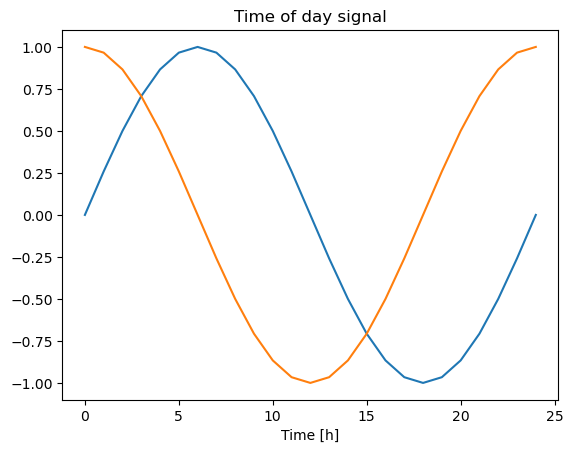

In [13]:
plt.plot(np.array(data['Day_sin'])[:25])
plt.plot(np.array(data['Day_cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

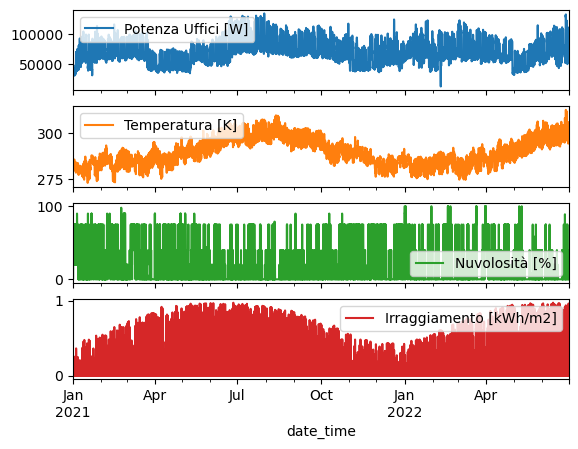

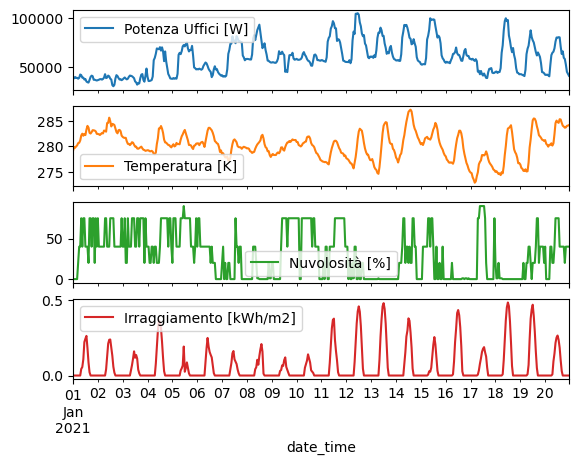

In [14]:
df['date_time'] = pd.to_datetime(
    df['Data'].dt.strftime('%Y-%m-%d') + ' ' + df['Ora'].astype(str).str.zfill(2) + ':00:00',
    format='%Y-%m-%d %H:%M:%S'
)

df.set_index('date_time', inplace=True)
plot_cols = ['Potenza Uffici [W]', 'Temperatura [K]', 'Nuvolosità [%]', 'Irraggiamento [kWh/m2]']

plot_features = df[plot_cols]
plot_features = df[plot_cols]  # Seleziona solo le colonne da plottare
_ = plot_features.plot(subplots=True)  # Plotta direttamente con l'indice già corretto

plot_features = df[plot_cols].iloc[:480]  # Seleziona le prime 480 righe
_ = plot_features.plot(subplots=True)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13104 entries, 0 to 13103
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Potenza Uffici [W]      13104 non-null  int64  
 1   Temperatura [K]         13104 non-null  float64
 2   Nuvolosità [%]          13104 non-null  int64  
 3   Irraggiamento [kWh/m2]  13104 non-null  float64
 4   Day_sin                 13104 non-null  float64
 5   Day_cos                 13104 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 614.4 KB


In [16]:
column_indices = {name: i for i, name in enumerate(data.columns)}

n = len(data)
train_data = data[0:int(n*0.7)]
val_data = data[int(n*0.7):int(n*0.9)]
test_data = data[int(n*0.9):]

num_features = data.shape[1]

In [17]:
train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std



/var/folders/fj/jf8_1bs122n5rv0h0w7bdgh00000gn/T/ipykernel_1557/3733287478.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(data.keys(), rotation=90)


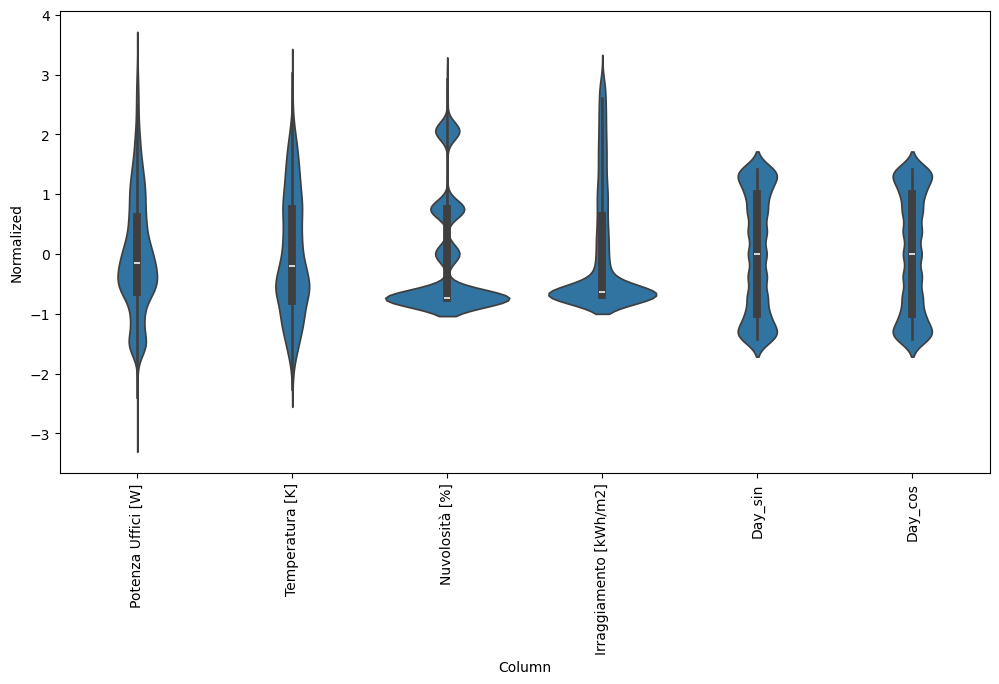

In [18]:
data_std = (data - train_mean) / train_std
data_std = data_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=data_std)
_ = ax.set_xticklabels(data.keys(), rotation=90)

In [19]:
def create_sequences_df(df, input_width=24, out_steps=1, target_col="Potenza Uffici [W]"):
    """
    df:        DataFrame Pandas
    input_width: numero di step passati da usare come input
    out_steps:   numero di step futuri da prevedere (se single-step => 1)
    target_col:  nome della colonna target
    
    Restituisce:
      - sequences: array NumPy di shape (n_examples, input_width, n_features)
      - labels:    array NumPy di shape (n_examples,) se out_steps=1
    """
    sequences = []
    labels = []
    
    for i in range(len(df) - input_width - out_steps + 1):
        # Finestra di input di lunghezza "input_width"
        seq_input = df.iloc[i : i + input_width].values
        # Finestra di output di lunghezza "out_steps"; qui assumiamo single-step => 1
        seq_label = df.iloc[i + input_width : i + input_width + out_steps][target_col].values
        
        sequences.append(seq_input)
        labels.append(seq_label)
        
    # Se out_steps=1, labels diventa di shape (N, 1). Possiamo "schiacciare" a (N, ):
    sequences = np.array(sequences)
    labels = np.array(labels)
    if out_steps == 1 and labels.ndim == 2:
        labels = labels.reshape(-1)
    
    return sequences, labels

input_width = 24
X_train, y_train = create_sequences_df(train_data, input_width=input_width, out_steps=24)
X_val,   y_val   = create_sequences_df(val_data,   input_width=input_width, out_steps=24)
X_test,  y_test  = create_sequences_df(test_data,  input_width=input_width, out_steps=24)

print("Shape X_train:", X_train.shape, "Shape y_train:", y_train.shape)
print("Shape X_val:",   X_val.shape,   "Shape y_val:",   y_val.shape)
print("Shape X_test:",  X_test.shape,  "Shape y_test:",  y_test.shape)


Shape X_train: (9125, 24, 6) Shape y_train: (9125, 24)
Shape X_val: (2574, 24, 6) Shape y_val: (2574, 24)
Shape X_test: (1264, 24, 6) Shape y_test: (1264, 24)


In [20]:
import numpy as np

X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)

# Definiamo gli indici
train_size = len(X_train)
val_size   = len(X_val)

train_indices = np.arange(0, len(X_train))
val_indices   = np.arange(len(X_train), len(X_train) + len(X_val))
custom_cv = [(train_indices, val_indices)]



In [21]:
class CampusGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_data, val_data, test_data,
                 label_columns):
        """
        Classe per gestire la finestratura (windowing) di dati temporali,
        focalizzata su due colonne di output di default:
        1) Potenza Uffici [W]
        2) Irraggiamento [kWh/m2]
        
        Parametri:
        ----------
        input_width  : lunghezza della finestra di input (numero di step temporali usati come input)
        label_width  : lunghezza della finestra di output (numero di step temporali da prevedere)
        shift        : numero di step tra la fine dell'input e l'inizio dell'output
        train_data     : DataFrame di training
        val_data       : DataFrame di validazione
        test_data      : DataFrame di test
        label_columns: lista di colonne da prevedere (default: [Potenza Uffici, Irraggiamento])
        """

        # 1) Salvataggio dei DataFrame
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data

        # 2) Memorizza i nomi delle colonne da prevedere (label)
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}

        # 3) Mappa i nomi di tutte le colonne dei DataFrame ai rispettivi indici
        self.column_indices = {name: i for i, name in enumerate(train_data.columns)}

        # 4) Parametri di finestra
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        # Grandezza totale della finestra
        self.total_window_size = input_width + shift

        # Slice per l'input (dall'indice 0 a input_width)
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        # Slice per le label (inizia da total_window_size - label_width)
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        """
        Override del metodo di stampa per dare informazioni utili
        sulle finestre generate (dimensioni di input e di output, nomi delle colonne, ecc.).
        """
        return '\n\n'.join([
            f"Total window size: {self.total_window_size}",
            f"Input indices: {self.input_indices}",
            f"Label indices: {self.label_indices}",
            f"Label column name(s): {self.label_columns}"
        ])

In [22]:
c1=CampusGenerator(input_width=24, label_width=24, shift=24, train_data=train_data,val_data=val_data, test_data=test_data,label_columns=["Potenza Uffici [W]"])
c1



Total window size: 48

Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]

Label column name(s): ['Potenza Uffici [W]']

In [23]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

CampusGenerator.split_window = split_window

In [24]:
c1.total_window_size

48

In [25]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_data[:c1.total_window_size])])
                           #np.array(train_df[100:100+c1.total_window_size]),
                           #np.array(train_df[200:200+c1.total_window_size])])

example_inputs, example_labels = c1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (1, 48, 6)
Inputs shape: (1, 24, 6)
Labels shape: (1, 24, 1)


In [26]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

CampusGenerator.make_dataset = make_dataset

In [27]:
MAX_EPOCHS = 100
START_FROM_EPOCH=75
def compile_and_fit(model, window, patience=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights=True,
                                                      start_from_epoch=START_FROM_EPOCH)
    if len(window.label_columns) == 2:
        model.compile(loss={'output1':tf.keras.losses.MeanSquaredError(),'output2':tf.keras.losses.MeanSquaredError()},
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics={'output1':[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()],
                        'output2':[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()]})

        history = model.fit(window.train, epochs=MAX_EPOCHS,
                            validation_data=window.val,
                            callbacks=[early_stopping])
    else:
        model.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])

        history = model.fit(window.train, epochs=MAX_EPOCHS,
                            validation_data=window.val,
                            callbacks=[early_stopping])

    # Valutazione con return_dict=True per ottenere i valori in un dizionario
    val_performance = model.evaluate(window.val, return_dict=True)
    test_performance = model.evaluate(window.test, return_dict=True)

    return history, val_performance, test_performance

In [28]:
@property
def train(self):
  return self.make_dataset(self.train_data)

@property
def val(self):
  return self.make_dataset(self.val_data)

@property
def test(self):
  return self.make_dataset(self.test_data)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

CampusGenerator.train = train
CampusGenerator.val = val
CampusGenerator.test = test
CampusGenerator.example = example

In [29]:
def plot(self, model=None, plot_col='Potenza Uffici [W]', max_subplots=5):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      if predictions.shape.ndims == 3:
        plt.scatter(self.label_indices, 
                    predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)
      elif predictions.shape.ndims == 2:
        plt.scatter(self.label_indices, 
                    predictions[n, :],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

CampusGenerator.plot = plot

Total window size: 48

Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]

Label column name(s): ['Potenza Uffici [W]']

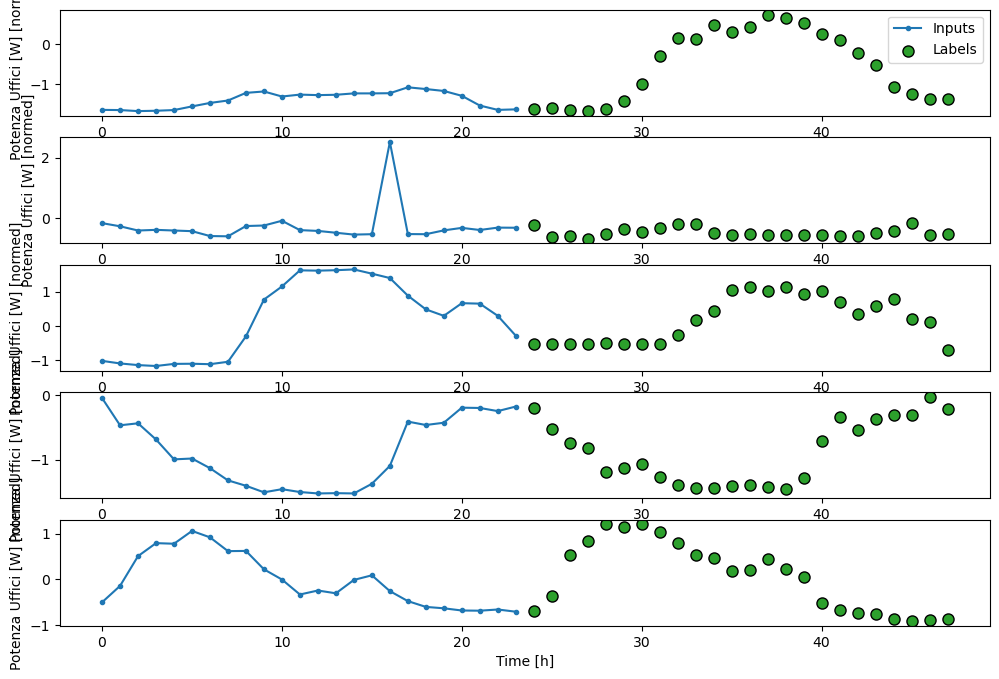

In [30]:
OUT_STEPS = 24
SHIFT_STEPS = 24 # è praticamente il prediction horizon
multi_campus = CampusGenerator(input_width=24,
                               train_data=train_data,val_data=val_data, test_data = test_data,
                               label_width=OUT_STEPS,
                               shift=SHIFT_STEPS,
                               label_columns=["Potenza Uffici [W]"]
                               )

multi_campus.plot()
multi_campus

In [31]:
'''multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS)
    # Shape => [batch, out_steps, features].
    #tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_campus)

multi_val_performance = {}
multi_performance = {}
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_campus.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_campus.test, verbose=0)
print(multi_val_performance, multi_performance)
multi_campus.plot(multi_lstm_model) '''


"multi_lstm_model = tf.keras.Sequential([\n    # Shape [batch, time, features] => [batch, lstm_units].\n    # Adding more `lstm_units` just overfits more quickly.\n    tf.keras.layers.LSTM(32, return_sequences=False),\n    # Shape => [batch, out_steps*features].\n    tf.keras.layers.Dense(OUT_STEPS)\n    # Shape => [batch, out_steps, features].\n    #tf.keras.layers.Reshape([OUT_STEPS, num_features])\n])\n\nhistory = compile_and_fit(multi_lstm_model, multi_campus)\n\nmulti_val_performance = {}\nmulti_performance = {}\nmulti_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_campus.val)\nmulti_performance['LSTM'] = multi_lstm_model.evaluate(multi_campus.test, verbose=0)\nprint(multi_val_performance, multi_performance)\nmulti_campus.plot(multi_lstm_model) "

In [32]:
from scikeras.wrappers import KerasRegressor
import tensorflow as tf
from sklearn.model_selection import GridSearchCV

lstm_units = 64
dropout_rate = 0.0
learning_rate = 0.001
dense_units = 24
def build_model(lstm_units=lstm_units, dense_units=dense_units, dropout_rate=dropout_rate, learning_rate=learning_rate, **kwargs):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(24, X_train.shape[2])),
        tf.keras.layers.LSTM(lstm_units, return_sequences=False, dropout=dropout_rate),
        tf.keras.layers.Dense(dense_units)  
    ])
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    return model

model_wrapper = KerasRegressor(
    model=build_model,
    verbose=0,
    flatten=False  
)


param_grid = {
    "model__lstm_units": [32, 64, 128],
    "model__dropout_rate": [0.0, 0.2],
    "model__learning_rate": [0.001, 0.0005],
    "batch_size": [12, 24, 36, 48],
    "epochs": [2]
}

grid_search = GridSearchCV(
    estimator=model_wrapper,
    param_grid=param_grid,
    cv=custom_cv,  # la fold che "blocca" train e val
    scoring="neg_mean_squared_error",
    verbose=1
)

# Fit su trainval (con fold personalizzata)
grid_search.fit(X_trainval, y_trainval)

print("Migliori iperparametri:", grid_search.best_params_)
print("Miglior punteggio:", grid_search.best_score_)




Fitting 1 folds for each of 48 candidates, totalling 48 fits


KeyboardInterrupt: 

In [ ]:
X_train.shape

In [ ]:

y_train.shape

In [ ]:
best_params = grid_search.best_params_

# Ricostruisci il modello con i migliori iperparametri
final_model = build_model(
    lstm_units=best_params["model__lstm_units"],
    dropout_rate=best_params["model__dropout_rate"],
    learning_rate=best_params["model__learning_rate"],
    dense_units= best_params["batch_size"]
)

X_train, y_train = create_sequences_df(train_data, input_width=best_params["batch_size"], out_steps=best_params["batch_size"])
X_test,  y_test  = create_sequences_df(test_data,  input_width=best_params["batch_size"], out_steps=best_params["batch_size"])

# Adesso, alleniamo il modello FINALE soltanto sul train set
final_model.fit(
    X_train, y_train,
    epochs=best_params["epochs"],
    batch_size=best_params["batch_size"],
    verbose=1,
)
test_mse, test_mae = final_model.evaluate(X_test, y_test, verbose=0)

print("MSE sul test set:", test_mse)
print("MAE sul test set:", test_mae)


In [ ]:
print(X_train.shape)

In [ ]:
print(y_train.shape)

In [ ]:
print(best_params["model__lstm_units"])

In [ ]:

multi_campus.plot(model=final_model, plot_col='Potenza Uffici [W]')

In [ ]:
import seaborn as sns
import numpy as np

errors = y_test - y_pred

plt.figure(figsize=(10, 5))
sns.histplot(errors, bins=50, kde=True)
plt.axvline(0, color='r', linestyle='dashed')
plt.xlabel("Errore (Valore Reale - Valore Predetto)")
plt.title("Distribuzione degli Errori")
plt.show()

**VEDI DA QUI** +


In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

# Supponiamo di avere un DataFrame 'data'
# 1. Suddivisione e standardizzazione dei dati
n = len(data)
train_data = data.iloc[:int(n*0.7)]
val_data   = data.iloc[int(n*0.7):int(n*0.9)]
test_data  = data.iloc[int(n*0.9):]

train_mean = train_data.mean()
train_std  = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data   = (val_data - train_mean) / train_std
test_data  = (test_data - train_mean) / train_std

# 2. Definizione dei parametri di windowing per la predizione sequence-to-sequence
input_width = 24   # lunghezza della sequenza di input (es. 24 ore)
label_width = 24   # lunghezza della sequenza target (predizione per le prossime 24 ore)
shift       = 24   # gap fra input e target (in questo caso, non c'è gap, basta che la finestra target sia alla fine)

total_window_size = input_width + shift  # lunghezza totale della finestra
''' 
# 3. Funzione per creare un tf.data.Dataset con batching
def make_dataset(data, input_width, label_width, shift, batch_size):
    data_array = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data_array,
        targets=None,
        sequence_length=total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=batch_size
    )
    
    # Funzione per dividere la finestra in input e target
    def split_window(window):
        inputs = window[:, :input_width, :]
        labels = window[:, -label_width:, :]
        return inputs, labels
    
    ds = ds.map(split_window)
    return ds
'''
def make_dataset(data, input_width, label_width, shift, batch_size, target_col="Potenza Uffici [W]"):
    # Converte il DataFrame in array numpy
    data_array = np.array(data, dtype=np.float32)
    total_window_size = input_width + shift
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data_array,
        targets=None,
        sequence_length=total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=batch_size
    )
    # Ottieni l'indice della colonna target
    target_col_index = data.columns.get_loc(target_col)
    
    def split_window(window):
        inputs = window[:, :input_width, :]
        # Seleziona solo la colonna target per le etichette:
        labels = window[:, input_width:input_width+label_width, target_col_index]
        # labels avrà forma (batch, label_width)
        return inputs, labels
    
    ds = ds.map(split_window)
    return ds
# Creiamo i dataset con un batch size placeholder (sarà sostituito dalla grid search nel training finale)
placeholder_batch_size = 32
train_ds = make_dataset(train_data, input_width, label_width, shift, placeholder_batch_size)
val_ds   = make_dataset(val_data, input_width, label_width, shift, placeholder_batch_size)
test_ds  = make_dataset(test_data, input_width, label_width, shift, placeholder_batch_size)

# Creiamo le sequenze specificando il target (ad es. "Potenza Uffici [W]")
def create_sequences_df(df, input_width=24, out_steps=24, target_col="Potenza Uffici [W]"):
    sequences = []
    labels = []
    for i in range(len(df) - input_width - out_steps + 1):
        seq_input = df.iloc[i : i + input_width].values
        # Selezioniamo solo la colonna target
        seq_label = df.iloc[i + input_width : i + input_width + out_steps][target_col].values
        sequences.append(seq_input)
        labels.append(seq_label)
    sequences = np.array(sequences)
    labels = np.array(labels)
    # Per out_steps > 1 manteniamo la shape (N, out_steps)
    return sequences, labels

# Creazione delle sequenze per la grid search
X_train, y_train = create_sequences_df(train_data, input_width=24, out_steps=24, target_col="Potenza Uffici [W]")
X_val,   y_val   = create_sequences_df(val_data,   input_width=24, out_steps=24, target_col="Potenza Uffici [W]")

# Uniamo training e validation per la grid search
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)

# Il modello, nel build_model, ha un output di 24 unità, quindi ora y_trainval ha shape (n_samples, 24)
def build_model(lstm_units=64, dense_units=24, dropout_rate=0.0, learning_rate=0.001, **kwargs):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(24, train_data.shape[1])),  # train_data.shape[1] indica il numero di feature
        tf.keras.layers.LSTM(lstm_units, dropout=dropout_rate),
        tf.keras.layers.Dense(dense_units)
    ])
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    return model





In [ ]:
y_trainval.shape

(11699, 24)

In [ ]:
X_trainval.shape

(11699, 24, 6)

In [34]:
# 5. Costruzione del modello (la struttura non dipende dal batch size)
def build_model(lstm_units=64, dense_units=24, dropout_rate=0.0, learning_rate=0.001, **kwargs):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_width, train_data.shape[-1])),
        tf.keras.layers.LSTM(lstm_units, dropout=dropout_rate),
        # Qui Dense restituisce un output "flattened"; per sequence-to-sequence si potrebbe usare un layer TimeDistributed
        tf.keras.layers.Dense(dense_units)
    ])
    
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    return model

# Wrapping per l'uso con GridSearchCV
model_wrapper = KerasRegressor(model=build_model, verbose=0, flatten=False)

# 6. Definizione della grid search sugli iperparametri, compreso il batch_size
param_grid = {
    "model__lstm_units": [32, 64, 128],
    "model__dropout_rate": [0.0, 0.2],
    "model__learning_rate": [0.001, 0.0005],
    "batch_size": [16, 32, 64],
    "epochs": [500]  
}

grid_search = GridSearchCV(
    estimator=model_wrapper,
    param_grid=param_grid,
    cv=custom_cv,
    scoring="neg_mean_squared_error",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_trainval, y_trainval)
print("Migliori iperparametri:", grid_search.best_params_)
print("Miglior punteggio:", grid_search.best_score_)

best_params = grid_search.best_params_


Fitting 1 folds for each of 36 candidates, totalling 36 fits
[CV] END batch_size=32, epochs=500, model__dropout_rate=0.0, model__learning_rate=0.001, model__lstm_units=32; total time= 8.1min
[CV] END batch_size=32, epochs=500, model__dropout_rate=0.0, model__learning_rate=0.001, model__lstm_units=64; total time=10.5min
[CV] END batch_size=16, epochs=500, model__dropout_rate=0.0, model__learning_rate=0.001, model__lstm_units=32; total time=14.7min
[CV] END batch_size=16, epochs=500, model__dropout_rate=0.0, model__learning_rate=0.0005, model__lstm_units=32; total time=14.8min
[CV] END batch_size=16, epochs=500, model__dropout_rate=0.2, model__learning_rate=0.0005, model__lstm_units=32; total time=14.9min
[CV] END batch_size=16, epochs=500, model__dropout_rate=0.2, model__learning_rate=0.001, model__lstm_units=32; total time=15.0min
[CV] END batch_size=16, epochs=500, model__dropout_rate=0.0, model__learning_rate=0.001, model__lstm_units=64; total time=17.7min
[CV] END batch_size=16, epo

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# 7. Costruzione del modello finale con i migliori iperparametri
final_model = build_model(
    lstm_units=best_params["model__lstm_units"],
    dropout_rate=best_params["model__dropout_rate"],
    learning_rate=best_params["model__learning_rate"],
    dense_units=24  # questo parametro può essere ulteriormente regolato se necessario
)

# Ricreiamo i dataset TF con il batch size ottimale dalla grid search
train_ds = make_dataset(train_data, input_width, label_width, shift, best_params["batch_size"])
val_ds   = make_dataset(val_data, input_width, label_width, shift, best_params["batch_size"])
test_ds  = make_dataset(test_data, input_width, label_width, shift, best_params["batch_size"])

# 8. Addestramento del modello finale
final_model.fit(
    train_ds,
    epochs=best_params["epochs"],
    validation_data=val_ds,
    verbose=1,
    callbacks=[early_stopping]
)
test_loss, test_mae = final_model.evaluate(test_ds, verbose=1)
print("Test loss:", test_loss, "Test MAE:", test_mae)

Epoch 1/500
571/571 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.4571 - mean_absolute_error: 0.5153 - val_loss: 0.3360 - val_mean_absolute_error: 0.4386
Epoch 2/500
571/571 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.3365 - mean_absolute_error: 0.4349 - val_loss: 0.3212 - val_mean_absolute_error: 0.4185
Epoch 3/500
571/571 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.3167 - mean_absolute_error: 0.4144 - val_loss: 0.2953 - val_mean_absolute_error: 0.3980
Epoch 4/500
571/571 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2932 - mean_absolute_error: 0.3970 - val_loss: 0.3303 - val_mean_absolute_error: 0.4231
Epoch 5/500
571/571 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2869 - mean_absolute_error: 0.3932 - val_loss: 0.3009 - val_mean_absolute_error: 0.4047
Epoch 6/500
571/571 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2789 - mean_absolute_error: 0.3866 - val_loss: 0.3240 - val_mean_absolute_error: 0.4097
Epoch 7/500
571/571 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2844 - mean_absolute_error: 0.3

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(inputs, labels, predictions, target_index, max_subplots=5):
    """
    inputs: array numpy di shape (num_samples, input_width, num_features)
    labels: array numpy di shape (num_samples, label_width) oppure (num_samples, label_width, num_features)
    predictions: array numpy di shape (num_samples, label_width) oppure (num_samples, label_width, num_features)
    target_index: indice della colonna target (per inputs e, se presente, per labels/predictions a 3D)
    max_subplots: numero massimo di subplot da mostrare
    """
    num_samples = min(max_subplots, inputs.shape[0])
    input_width = inputs.shape[1]
    # Assumiamo che il label_width sia la seconda dimensione di labels (se 2D)
    label_width = labels.shape[1] if labels.ndim == 2 else labels.shape[1]
    
    plt.figure(figsize=(12, num_samples * 3))
    
    for n in range(num_samples):
        plt.subplot(num_samples, 1, n + 1)
        
        # Time axis per gli input: 0 ... input_width-1
        x_input = np.arange(input_width)
        plt.plot(x_input,
                 inputs[n, :, target_index],
                 label="Input", marker=".", linestyle="-")
        
        # Time axis per le label e le previsioni: input_width ... input_width+label_width-1
        x_future = np.arange(input_width, input_width + label_width)
        
        # Estrae le label: se labels è 3D, prendi la colonna target; se è 2D usala direttamente
        if labels.ndim == 3:
            label_values = labels[n, :, target_index]
        else:
            label_values = labels[n, :]
        
        plt.scatter(x_future,
                    label_values,
                    label="Label", color="green", s=64)
        
        # Estrae le previsioni in modo simile
        if predictions.ndim == 3:
            pred_values = predictions[n, :, target_index]
        else:
            pred_values = predictions[n, :]
        
        plt.scatter(x_future,
                    pred_values,
                    label="Prediction", marker="x", color="red",
                    s=64)
        
        if n == 0:
            plt.legend()
        plt.xlabel("Time step")
    
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


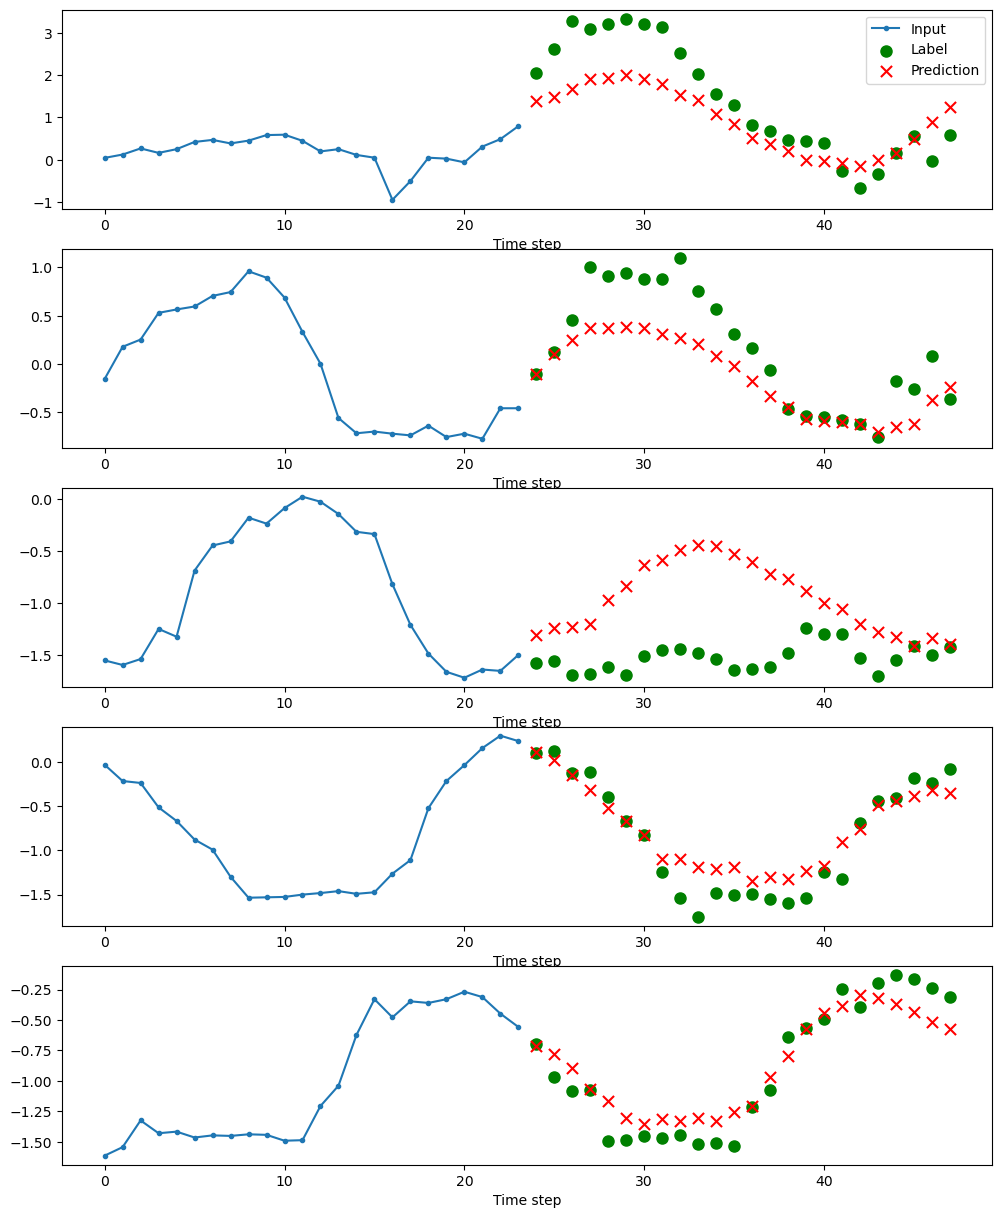

In [53]:
for test_inputs, test_labels in test_ds.take(1):
    test_predictions = final_model.predict(test_inputs)
    break

target_col = "Potenza Uffici [W]"
target_index = data.columns.get_loc(target_col)

plot_predictions(test_inputs.numpy(), test_labels.numpy(), test_predictions, target_index, max_subplots=5)

In [54]:
n_iterations = 60  # 60 iterazioni * 24 step = 1440 ore

# Otteniamo l'ultimo window di input conosciuto (input_width = 24)
last_window = data.iloc[-input_width:].values  # shape: (24, num_features)

current_window = last_window.copy()
future_predictions = []

target_col = "Potenza Uffici [W]"
target_index = data.columns.get_loc(target_col)

for i in range(n_iterations):
    pred = final_model.predict(np.expand_dims(current_window, axis=0))  # shape: (1, 24)
    pred = pred[0]  # forma: (24,)
    
    future_predictions.append(pred)
    
    # Crea nuove righe con i valori predetti
    new_rows = np.repeat(current_window[-1:], 24, axis=0)  # forma: (24, num_features)
    new_rows[:, target_index] = pred  # sostituisce il target con i valori predetti
    
    # Aggiorna la finestra: aggiungi le nuove righe e prendi le ultime 24 righe
    current_window = np.concatenate([current_window, new_rows], axis=0)[-input_width:]
    
# Unisci le predizioni in un array singolo: (60 * 24 = 1440,)
future_predictions = np.concatenate(future_predictions, axis=0)

print("Predizioni future (1440 step):", future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━